# Challenge Description
Company XYZ is a worldwide e-commerce site with localized versions of the site.

A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than
any other Spanish-speaking country. She therefore went and talked to the international team in
charge of Spain And LatAm to see if they had any ideas about why that was happening.

Spain and LatAm country manager suggested that one reason could be translation. All Spanish-speaking countries had the same translation of the site which was written by a Spaniard. They
agreed to try a test where each country would have its one translation written by a local. That is,
Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican
and so on. Obviously, nothing would change for users from Spain.

After they run the test however, they are really surprised cause the test is negative. I.e., it
appears that the non-localized translation was doing better!

You are asked to:
- Confirm that the test is actually negative. That is, it appears that the old version of the 
site with just one translation across Spain and LatAm performs better
- Explain why that might be happening. Are the localized translations really worse?
- If you identified what was wrong, design an algorithm that would return FALSE if the
same problem is happening in the future and TRUE if everything is good and the results
can be trusted。

In [78]:
import numpy as np
import pandas as pd
from my_utils import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from pandas.api.types import is_numeric_dtype, is_categorical_dtype
from numpy.random import seed

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')

In [79]:
#load in the datasets
df_test = pd.read_csv('test_table.csv')
df_user = pd.read_csv('user_table.csv')
print(df_test.head())
print('\n')
print(df_user.head())

   user_id        date  source  device browser_language ads_channel  \
0   315281   12/3/2015  Direct     Web               ES         NaN   
1   497851   12/4/2015     Ads     Web               ES      Google   
2   848402   12/4/2015     Ads     Web               ES    Facebook   
3   290051   12/3/2015     Ads  Mobile            Other    Facebook   
4   548435  11/30/2015     Ads     Web               ES      Google   

       browser  conversion  test  
0           IE           1     0  
1           IE           0     1  
2       Chrome           0     0  
3  Android_App           0     1  
4      FireFox           0     1  


   user_id sex  age    country
0   765821   M   20     Mexico
1   343561   F   27  Nicaragua
2   118744   M   23   Colombia
3   987753   F   27  Venezuela
4   554597   F   20      Spain


### Data exploration

In [80]:
# Check the number of unique users from both tables
df_test.user_id.nunique(), df_user.user_id.nunique()

(453321, 452867)

In [81]:
# Join the two tables to get a whole picture
df = pd.merge(df_test, df_user, how = 'inner', on = 'user_id')
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,12/3/2015,Direct,Web,ES,NaN,IE,1,0,M,32,Spain
1,497851,12/4/2015,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
2,848402,12/4/2015,Ads,Web,ES,Facebook,Chrome,0,0,M,34,Spain
3,290051,12/3/2015,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico
4,548435,11/30/2015,Ads,Web,ES,Google,FireFox,0,1,M,19,Mexico


In [82]:
df.dtypes

user_id              int64
date                object
source              object
device              object
browser_language    object
ads_channel         object
browser             object
conversion           int64
test                 int64
sex                 object
age                  int64
country             object
dtype: object

In [83]:
target = 'conversion'

In [84]:
print('test group:')
print(df[df['test']==1].describe().transpose())
print('\n')
print('control group:')
print(df[df['test']==0].describe().transpose())

test group:
               count           mean            std   min        25%       50%  \
user_id     215774.0  499483.813462  288529.156089   3.0  249801.75  499125.0   
conversion  215774.0       0.043411       0.203781   0.0       0.00       0.0   
test        215774.0       1.000000       0.000000   1.0       1.00       1.0   
age         215774.0      27.115236       6.762929  18.0      22.00      26.0   

                  75%       max  
user_id     748968.75  999999.0  
conversion       0.00       1.0  
test             1.00       1.0  
age             31.00      70.0  


control group:
               count           mean            std   min       25%       50%  \
user_id     237093.0  500364.345278  288810.049480   1.0  249846.0  500927.0   
conversion  237093.0       0.055156       0.228284   0.0       0.0       0.0   
test        237093.0       0.000000       0.000000   0.0       0.0       0.0   
age         237093.0      27.144850       6.789151  18.0      22.0      26.

In [85]:
col = 'country'
summary = df[df['country'] !='Spain'].groupby([col, 'test'], as_index=False)[target].agg(['mean','count']).reset_index()
summary

,country,test,mean,count
0,Argentina,0,0.015071,9356
1,Argentina,1,0.013725,37377
2,Bolivia,0,0.049369,5550
3,Bolivia,1,0.047901,5574
4,Chile,0,0.048107,9853
5,Chile,1,0.051295,9884
6,Colombia,0,0.052089,27088
7,Colombia,1,0.050571,26972
8,Costa Rica,0,0.052256,2660
9,Costa Rica,1,0.054738,2649


In all these countries, Argentina and Uruguay have very unbalanced test/control groups, while all the other countries seem to have a comparable size.
Spain is not in the test group so we exclude it from the dataset. Besides, we also exclude Argentina and Uruguay from the dataset to further check the conversion for each group on differen dimensions.

In [86]:
df1 = df[(df['country'] !='Spain' ) & (df['country'] !='Argentina' ) & (df['country'] !='Uruguay' )]

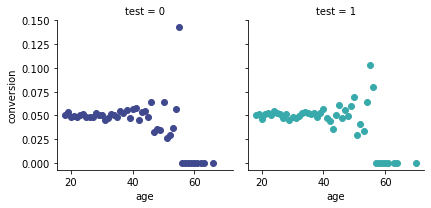

In [87]:
s = df1.groupby(['age','test'], as_index=False)[target].mean()
g = sns.FacetGrid(data=s, col='test', palette='mako', hue = 'test')
g.map(plt.scatter,  'age', target)

In [138]:
df['age'].quantile(0.95)

40.0

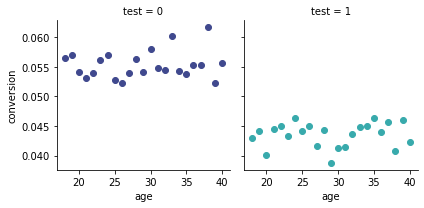

In [89]:
# Outliers are observed for age, let's cap the data range.
df['age'].clip(upper=40, inplace=True)

s = df.groupby(['age','test'], as_index=False)[target].mean()
g = sns.FacetGrid(data=s, col='test', palette='mako', hue = 'test')
g.map(plt.scatter,  'age', target)

In [91]:
# Visualize the conversion rate on other dimensions.
categoric = ['source', 'device','browser_language', 'ads_channel', 'browser', 'sex']

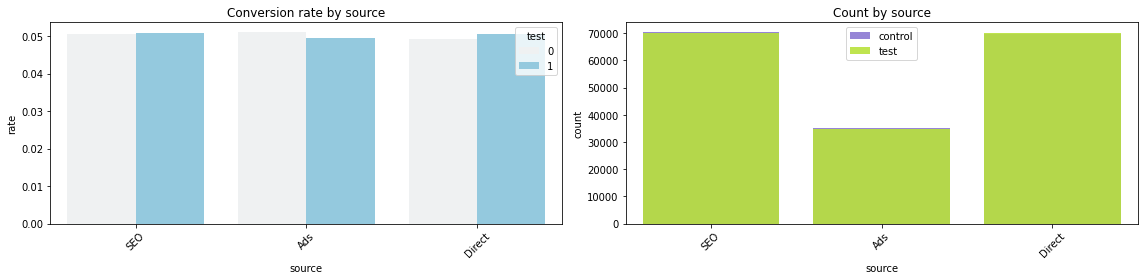

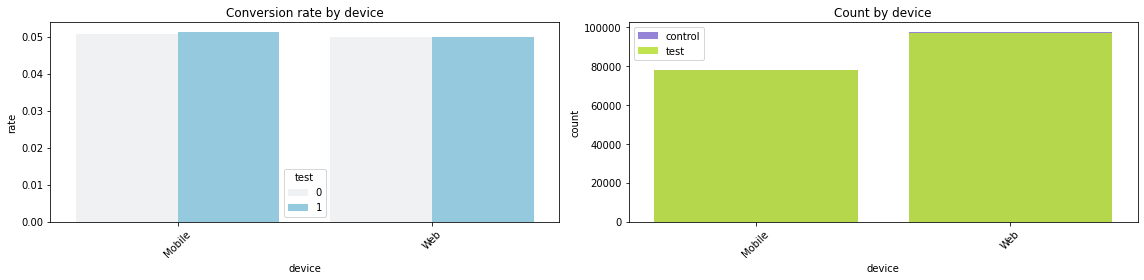

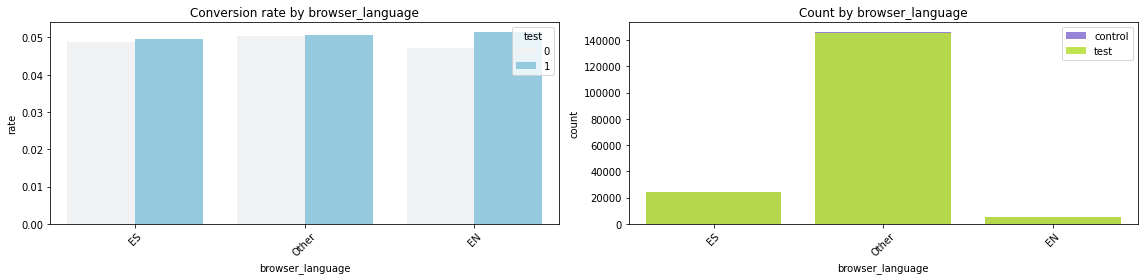

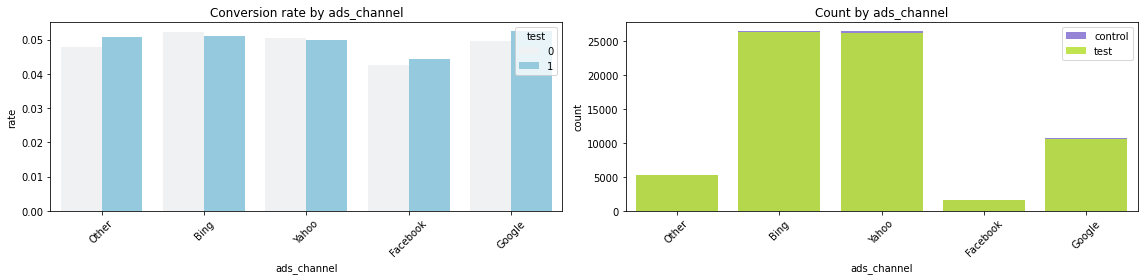

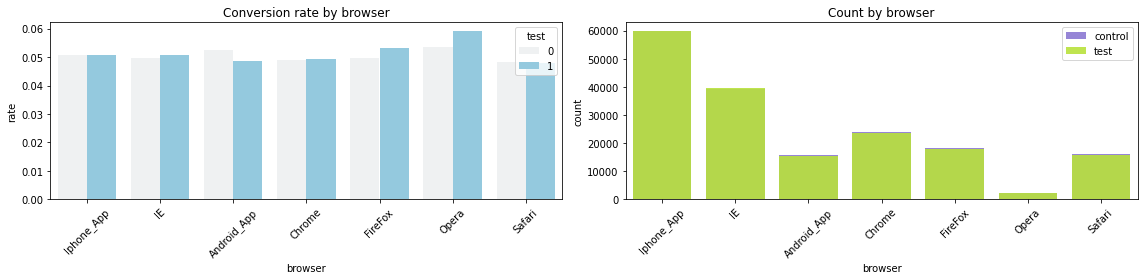

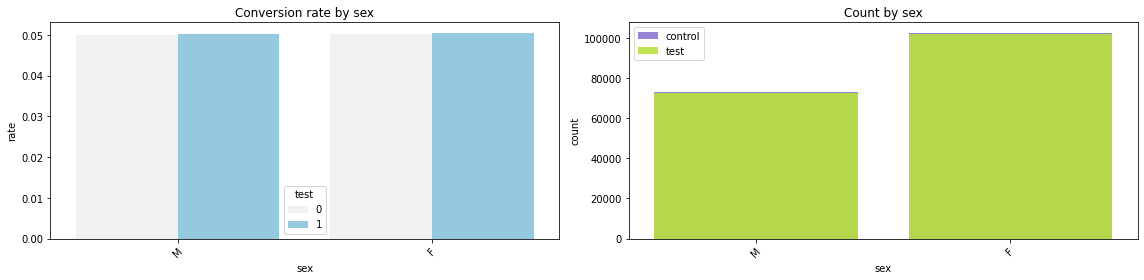

In [92]:
for col in categoric:
    summary  = df1.groupby([col, 'test']).agg({target: ['mean','count']}).reset_index()
    summary.columns = [col, 'test', 'rate', 'count']
    
    
    fig, ax = plt.subplots(ncols = 2, nrows =1, figsize = (16, 4))
    sns.barplot(x = col, y = 'rate', hue = 'test', data =summary, ax = ax[0], color = 'skyblue')
    xlabels = list(set(summary[col].tolist()))
    ax[0].set_title('Conversion rate by {}'.format(col))
    ax[0].set_xticklabels(xlabels, rotation=45)
    
    sns.barplot(x=col, y = 'count',  data = summary[summary['test']==0], ax= ax[1], color ='#5f3dd9', alpha=.7 ,label = 'control')
    sns.barplot(x=col, y = 'count',  data = summary[summary['test']==1], ax= ax[1], color ='#c6fc21',  alpha=.9, label = 'test')
    ax[1].set_title('Count by {}'.format(col)) 
    ax[1].set_xticklabels(xlabels, rotation=45)
    ax[1].legend()
    plt.tight_layout()
    plt.show()

Before running any test. let's do some sanity checks.

Check if each user only appear once during the period in the same group.

In [143]:
user0 = df[df['test']==0]['user_id'].value_counts()
user1 = df[df['test']==1]['user_id'].value_counts()
print('{} users from control group appeared more than once during the test period.'.format(user0.gt(1).sum()))
print('{} users from test group appeared more than once during the test period.'.format(user1.gt(1).sum()))

0 users from control group appeared more than once during the test period.
0 users from test group appeared more than once during the test period.


 Check whether there is mixed assignment.

In [146]:
user0_list = df[df[target]==0]['user_id'].unique().tolist()
user1_list = df[df[target]==1]['user_id'].unique().tolist()
if np.intersect1d(user0_list, user1_list):
    print('There are {} users were assigned to both groups'.format(count(np.intersect1d(user0_list, user1_list))))
else:
    print('There is no mixed assignment.')

There is no mixed assignment.


### Compare the daily conversion rates from control group and test group.

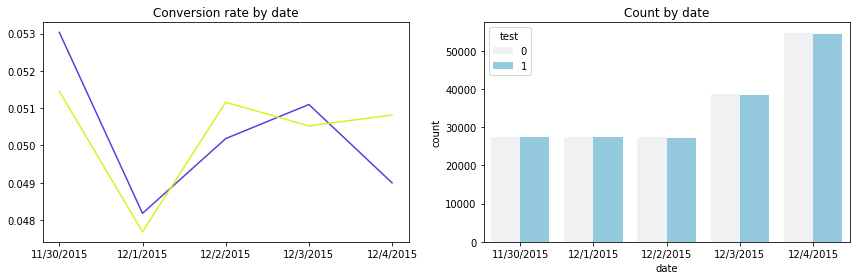

In [96]:
summary = df1.groupby(['date', 'test']).agg(['mean','count'])[target].reset_index()

fig, ax = plt.subplots(nrows=1, ncols =2, figsize = (12, 4))
ax[0].plot(summary[summary['test']==0]['date'], summary[summary['test']==0]['mean'], label = 'test==0', color = '#5f3dd9')
ax[0].plot(summary[summary['test']==1]['date'], summary[summary['test']==1]['mean'], label = 'test==0', color = '#c6fc21')
ax[0].set_title('Conversion rate by date')

sns.barplot(x='date', y='count', hue = 'test', data = summary, ax= ax[1], color ='skyblue')
ax[1].set_title('Count by date')
plt.tight_layout()
plt.show()
# test was running from 11/30/2015 to 12/4/2015

In [97]:
df_t = pd.pivot_table(df1[df1['test']==1], columns='date', values = target, aggfunc = 'mean').transpose().reset_index()
df_c = pd.pivot_table(df1[df1['test']==0], columns='date', values = target, aggfunc = 'mean').transpose().reset_index()

df_compare = pd.merge(df_t, df_c, how= 'inner', on = 'date', suffixes=('_t', '_c'))
df_compare = df_compare.rename(columns = {'conversion_t':'test','conversion_c':'control' })
df_compare

,date,test,control
0,11/30/2015,0.051452,0.053032
1,12/1/2015,0.047685,0.048181
2,12/2/2015,0.051157,0.050185
3,12/3/2015,0.050525,0.051098
4,12/4/2015,0.050817,0.048999


### Run the test

Before running any test on the difference of control/treatment group means, first check whether the conversion rates for each 
group meet the assumption of normality by running the Shapir-Wilk test.

In [148]:
seed(1)
alpha = 0.05

for col in ['test','control']:
    stat, p  = shapiro(df_compare[col])
    if p >alpha:
        print('{} sample looks Guassian with {} as test value and {} as p value'.format(col, round(stat,3), round(p,4)))
    else:
        print('{} sample does not looks Gaussian with {} as test value and {} as p value.'.format(col, round(stat,3), round(p,4)))

test sample does not looks Gaussian with 0.766 as test value and 0.0413 as p value.
control sample looks Guassian with 0.974 as test value and 0.8975 as p value


Since not both samples meet the normality assumption for two sample t-test, we need to run Mann-Whitney U test or Wilcoxon rank sum test to see if both sample have equal median.

In [100]:
# perform two-sided test.
result = stats.mannwhitneyu(x = df_compare['test'], y = df_compare['control'], alternative = 'two-sided')
result

MannwhitneyuResult(statistic=14.0, pvalue=0.8345316227109287)

Based on the test result, we cannot tell the two sample medians are statistically significant from each other, which is within my expectation since the sample sizes are really small. 
we only have five days of data, not even enough to cover a whole week!
In order to design a meaningful test, we should always calculate the to understand the sample size needed first.

Calculate the sample size needed for an A/B test. The following sample size calculation formular can be found at [Standford Lecture](https://web.stanford.edu/~kcobb/hrp259/lecture11.ppt)

<img src="Capture.jpg" width="250" height="200">

In [150]:
u1 = df1[df1['test']==1][target].mean() # test group sample mean
u2 = df1[df1['test']==0][target].mean() # control group sample mean

In [134]:
z_alpha = stats.norm.isf(sig/2)
z_power = stats.norm.isf(power)  
d = u1 - u2
p = (u1 + u2) 
n = int(2 * p * (1-p) * (z_alpha + z_power)**2 / (d**2))

print('The sample size we need is {}.'.format(n))
print('On average, each day, we can get {} samples.'.format(round(df1.shape[0]/5)))
print('We need to run the test for {} days.'.format(round(n/(df1.shape[0]/5))))

The sample size we need is 3230375.
On average, each day, we can get 70044 samples.
We need to run the test for 46 days.


### Summary and recommendations
- After we exclude the unbalanced countries' data, there is no statistically significant difference in conversion rate for test 
group and control group.
- In order to make a solid conclusion on the test effect, we need to have large enough sample size, which requires us to keep 
the test running for 46 days based on current visitor volume we have. 
- We may start using a smaller proportion of the whole population to run the experiment if that can lower down our cost and have less impact on our users, but it will also extend the experiment period accordingly.
- If we are going to run the experiment again in the future, we want to make sure that our control/test group are assigned with similar proportion (preferably evently so that we can have a balanced test) on all the dimensions.

In [155]:
os.getcwd()

'D:\\TakeHomeExercises\\Spanish Translation AB Test'